## dataset.ipynb: preprocess the dataset 

In [1]:
# Import the necessary libraries
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage
from spectral import *

In [2]:
#  load the Indian pines dataset which is the .mat format
def loadIndianPinesData():
    data_path = os.path.join(os.getcwd(), 'data')
    data = sio.loadmat(os.path.join(data_path, 
                      'Indian_pines.mat'))['indian_pines']
    labels = sio.loadmat(os.path.join(data_path, 
                        'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels

In [3]:
#  load the Indian pines dataset which is HSI format
#  refered from http://www.spectralpython.net/fileio.html
def loadHSIData():
    data_path = os.path.join(os.getcwd(), 'HSI_data')
    data = open_image(os.path.join(data_path, '92AV3C.lan')).load()
    data = np.array(data).astype(np.int32)
    labels = open_image(os.path.join(data_path, '92AV3GT.GIS')).load()
    labels = np.array(labels).astype(np.uint8)
    labels.shape = (145, 145)
    return data, labels

In [4]:
#  split data to Train and Test Set
def splitTrainTestSet(X, y, classnum=15, testRatio=0.50):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                test_size=testRatio, random_state=345, stratify=y)
    ss=StratifiedShuffleSplit(n_splits=classnum, test_size=testRatio, 
                              train_size=1-testRatio, random_state=0)
    
    for train_index, test_index in ss.split(X, y):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    return X_train, X_test, y_train, y_test

In [5]:
#  over sample 
def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), 
                                                   axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

In [6]:
#  standartize
def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    scaler = preprocessing.StandardScaler().fit(newX)  
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler

In [7]:
#  apply PCA preprocessing for data sets
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [8]:
#  pad zeros to dataset
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, 
                     X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + 
         y_offset, :] = X
    return newX

In [9]:
#  create Patches for dataset
def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, 
                            windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - 
                                margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [10]:
#  Augment Data
def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, 
                            no,axes=(1, 0), reshape=False, output=None, 
                            order=3, mode='constant', cval=0.0, prefilter=False)
        
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train

In [11]:
# save Preprocessed Data to file
def savePreprocessedData(path, X_trainPatches, X_testPatches, y_trainPatches, 
                         y_testPatches, X_all, y_all, windowSize, wasPCAapplied = False, 
                         numPCAComponents = 0, testRatio = 0.25):
    
    data_path = os.path.join(os.getcwd(), path)

    if wasPCAapplied:
        with open(os.path.join(data_path, "XtrainWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open(os.path.join(data_path, "XtestWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open(os.path.join(data_path, "ytrainWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open(os.path.join(data_path, "ytestWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
        
        with open(os.path.join(data_path, "XAllWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_all)
        with open(os.path.join(data_path, "yAllWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_all)
    else:
        with open(os.path.join(data_path, "preXtrainWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open(os.path.join(data_path, "preXtestWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open(os.path.join(data_path, "preytrainWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open(os.path.join(data_path, "preytestWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
            

In [12]:
# Global Variables
# The number of principal components to be retained in the PCA algorithm, 
# the number of retained features  n
numComponents = 30
# Patches windows size
windowSize = 5
# The proportion of Test sets
testRatio = 0.50

In [13]:
# Load dataset from file and apply PCA
X, y = loadHSIData()
# X, y = loadIndianPinesData()
X, pca = applyPCA(X, numComponents=numComponents)

/home/danquxunhuan/software/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  """
/home/danquxunhuan/software/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  import sys


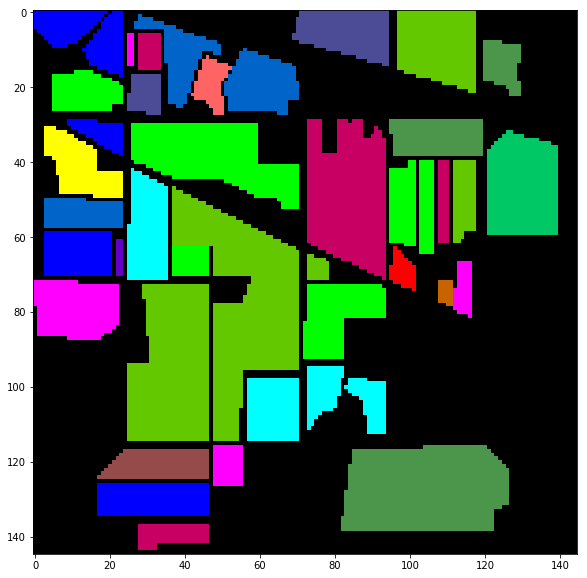

In [19]:
ground_truth = imshow(classes=y, figsize=(10, 10))

In [15]:
# Preprocess Data
XPatches, yPatches = createPatches(X, y, windowSize=windowSize)
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, 
                                                     y.max()-y.min(), testRatio)
X_all = np.append(X_train, X_test, axis=0)
y_all = np.append(y_train, y_test, axis=0)
X_train, y_train = oversampleWeakClasses(X_train, y_train)
# X_all, y_all = oversampleWeakClasses(X_all, y_all)
X_train = AugmentData(X_train)
# X_all = AugmentData(X_all)

TRAIN: [6228 5433 9068 ..., 6743 1956 5287] TEST: [6159 3690 1423 ..., 7373 7667 5231]
TRAIN: [9741 8674 4677 ..., 2543 6831 7107] TEST: [7834  635 7863 ..., 1411 9564 6582]
TRAIN: [4699 2425 8371 ..., 4667 1341 6601] TEST: [5914 7286 4555 ..., 9994 5248 4507]
TRAIN: [1128 7376 8303 ..., 8154 1713 7514] TEST: [8416 4451 9407 ...,  128 9131 2022]
TRAIN: [7077 7380 7023 ..., 1518  720 8867] TEST: [ 975 2215 1371 ..., 6299 9906 8774]
TRAIN: [4174 8826 3937 ..., 9760 7241 1498] TEST: [ 144 3988 3306 ..., 2533  284 2577]
TRAIN: [3673 7056 4972 ...,  415 6482 5468] TEST: [8497  729 8776 ..., 6593 7431 5360]
TRAIN: [ 224 2303 1642 ..., 3312  143 2647] TEST: [7518 8709 6382 ..., 4977 3821  979]
TRAIN: [ 9600  1863  1008 ...,  7978 10116  2572] TEST: [3019 9211 2306 ..., 9271 2746  444]
TRAIN: [4841 9831 9919 ..., 7982 9983 4699] TEST: [4355 1061 5446 ..., 8593 9958 9408]
TRAIN: [4090 7025 6901 ..., 6453  790 2484] TEST: [9144 5630 7684 ..., 6917  260 7931]
TRAIN: [ 8413  1117  8932 ...,  1879 

In [16]:
# save Preprocessed Data to file
savePreprocessedData('predata', X_train, X_test, y_train, y_test, 
                     X_all, y_all, windowSize = windowSize, 
                     wasPCAapplied=True, numPCAComponents = numComponents, 
                     testRatio = testRatio)

In [17]:
# from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
# XPatches, yPatches = createPatches(X, y, windowSize=windowSize)
# ss=StratifiedShuffleSplit(n_splits=y.max()-y.min(), test_size=testRatio, 
#                               train_size=1-testRatio, random_state=0)
    
# for train_index, test_index in ss.split(XPatches, yPatches):
#     print("TRAIN:", train_index, "TEST:", test_index)#获得索引值
#     X_train, X_test = XPatches[train_index], XPatches[test_index]#训练集对应的值
#     y_train, y_test = yPatches[train_index], yPatches[test_index]#类别集对应的值

In [18]:
# print(X_train.size)
# print(y_train.size)
# print(X_test.size)
# print(y_test.size)